In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import datetime
from scipy import stats
from math import sqrt
import math,os

In [3]:
#录入path路径下所有的'.npy'结尾的文件
path = 'C:/Users/Administrator/Documents'

#获取所有path下所有文件
dirs = os.listdir(path)
data = {}
#开始录入
for x in dirs:
    #如果以.npy结尾则录入
    if os.path.splitext(x)[1]=='.npy':
        name = os.path.splitext(x)[0]
        file = path+'\\'+x
        value = np.load(file)
        data[name]=value
        
#展示录入的所有文件
data.keys()

dict_keys(['AdjFactor', 'BPS', 'BSQ0_TOT_ASSETS', 'CAPQ0_FLOAT_A', 'CAPQ0_FLOAT_A_SHR', 'ClosePrice', 'ClosePrice_index', 'dates', 'EPS_BASIC', 'EPS_dates', 'EPS_ticker_names', 'fd_dates', 'fd_tic', 'FIQ0_S_FA_BPS', 'FIQ0_S_FA_ROE', 'HighestPrice', 'index_ClosePrice', 'index_ticker_names', 'l2_dates', 'l2_ticker_names', 'LowestPrice', 'OpenPrice', 'PRC', 'S_LI_INITIATIVEBUYRATE', 'S_LI_INITIATIVESELLRATE', 'ticker_names', 'ticker_names_index', 'ticker_names_wind', 'TradeStatus', 'TradingDays', 'Turnover', 'Volume', 'VWAP', 'WIND_IDX_INDCLS2_MEMBER', 'WIND_INDCLS_MEMBER'])

In [4]:
#获取因子CVD的原始数据cashvol
#这里因为没有直接的cashvol，我采用了vwap*volume
#首先读取index 和 colume
tic = data['ticker_names']
dates = pd.to_datetime(data['dates'])
fd_dates = pd.to_datetime(data['fd_dates'])
fd_tick = data['fd_tic']

#读取vwap volume close以及和fama模型相关的市值，BP，ROE，资产回报率
vwap = pd.DataFrame(data['VWAP'],index = tic,columns=dates).T
volume = pd.DataFrame(data['Volume'],index = tic,columns=dates).T
ClosePrice = pd.DataFrame(data['ClosePrice'],index = tic,columns=dates).T
MarketCap = pd.DataFrame(data['CAPQ0_FLOAT_A'],index = tic,columns=dates).T
BPS = pd.DataFrame(data['FIQ0_S_FA_BPS'].T,index = fd_dates,columns=fd_tick)[tic]
TotalAsset = pd.DataFrame(data['BSQ0_TOT_ASSETS'].T,index = fd_dates,columns=fd_tick)[tic]
ROE = pd.DataFrame(data['FIQ0_S_FA_ROE'].T,index = fd_dates,columns=fd_tick)[tic]

#相乘得到cashvol
cashvol = vwap*volume
cashvol.tail()

000001        000002  000003         000004        000005  \
2021-03-29  1.684399e+07  1.608547e+07     NaN  273699.450882  1.751105e+06   
2021-03-30  1.601241e+07  1.496309e+07     NaN  255561.853904  1.026442e+06   
2021-03-31  1.699920e+07  3.512098e+07     NaN  191878.159800  6.197014e+05   
2021-04-01  1.183866e+07  1.565414e+07     NaN  220583.181300  6.230953e+05   
2021-04-02  1.249405e+07  1.140365e+07     NaN  193377.905700  3.372275e+05   

                   000006        000007         000008        000009  \
2021-03-29  637477.499875  7.134163e+05  278512.616016  5.981085e+06   
2021-03-30  396216.009475  8.864364e+05  325815.080181  2.730088e+06   
2021-03-31  319902.308362  1.236825e+06  262048.249080  2.332909e+06   
2021-04-01  424468.721100  2.510364e+06  245680.989200  1.565293e+06   
2021-04-02  292467.849258  1.923266e+06  226876.810395  4.545797e+06   

                  000010  ...         688687        688689        688696  \
2021-03-29  2.018470e+06  ...  280986.609522  2.826618e+05  3.190367e+06   
2021-03-30  1.562110e+06  ...  178510.185084  9.574994e+05  3.995656e+06   
2021-03-31  9.509848e+05  ...  236619.655920  4.580838e+05  2.156703e+06   
2021-04-01  8.141763e+05  ...  333112.680760  1.016516e+06  2.283602e+06   
2021-04-02  1.161255e+06  ...  323720.187320  1.522124e+06  2.792338e+06   

                   688698        688699        688777         688788  \
2021-03-29  286706.305600  9.603500e+05  4.946481e+05  288811.891710   
2021-03-30  477311.888886  1.586180e+06  1.056387e+06  375029.560704   
2021-03-31  429567.267780  1.152185e+06  9.292451e+05  436837.467952   
2021-04-01  172722.845178  1.135719e+06  1.739255e+06  257904.767427   
2021-04-02  211250.257244  2.441277e+06  1.621101e+06  417874.389570   

                  688819        688981  T00018  
2021-03-29  3.727479e+06  9.630752e+06     NaN  
2021-03-30  2.141401e+06  6.521827e+06     NaN  
2021-03-31  1.412536e+06  5.708686e+06     NaN  
2021-04-01  1.614669e+06  1.598275e+07     NaN  
2021-04-02  1.584259e+06  3.221559e+07     NaN  

[5 rows x 4368 columns]

In [5]:
#对fama5因子相关数据进行数据处理，获得SMB HML RMW CMA的原始对应数据
TotalAsset = TotalAsset.resample('M').last()
TotalAsset = np.log(TotalAsset)-np.log(TotalAsset.shift(1))
TotalAsset[abs(TotalAsset)==np.inf]=np.nan
ROE = ROE.resample('M').last()
BPS = BPS.resample('M').last()
MC = MarketCap.resample('M').last()


<ipython-input-5-6eeb4c075102>:3: RuntimeWarning: divide by zero encountered in log
  TotalAsset = np.log(TotalAsset)-np.log(TotalAsset.shift(1))


In [6]:
#对数据进行按月聚合
ClosePrice = ClosePrice.resample('M').last()

#取log return
Re = np.log(ClosePrice.shift(-1)) - np.log(ClosePrice)
Re 

000001    000002  000003    000004    000005    000006  \
1990-12-31       NaN       NaN     NaN       NaN  1.434089       NaN   
1991-01-31       NaN  0.023817     NaN -0.043500 -0.030324       NaN   
1991-02-28       NaN -0.052937     NaN -0.135045 -0.135090       NaN   
1991-03-31       NaN -0.119241     NaN -0.101956 -0.124136       NaN   
1991-04-30  0.212829 -0.020814     NaN -0.121592 -0.131278       NaN   
...              ...       ...     ...       ...       ...       ...   
2020-12-31  0.177224 -0.032221     NaN -0.021485 -0.167413 -0.143512   
2021-01-31 -0.076944  0.174857     NaN -0.072136  0.000000  0.059898   
2021-02-28  0.029041 -0.098336     NaN -0.098019  0.122962  0.041752   
2021-03-31 -0.023444  0.000000     NaN  0.011635 -0.046520  0.001857   
2021-04-30       NaN       NaN     NaN       NaN       NaN       NaN   

              000007    000008    000009    000010  ...    688687    688689  \
1990-12-31       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1991-01-31       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1991-02-28       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1991-03-31       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1991-04-30       NaN       NaN       NaN       NaN  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2020-12-31 -0.970836 -0.023906 -0.090276 -0.049814  ...       NaN       NaN   
2021-01-31  0.430404 -0.053843  0.341443 -0.035571  ...       NaN -0.354421   
2021-02-28 -0.047928 -0.025864 -0.109040  0.132835  ... -0.176642 -0.051044   
2021-03-31  0.045462  0.000000  0.053825  0.016929  ...  0.008655  0.109343   
2021-04-30       NaN       NaN       NaN       NaN  ...       NaN       NaN   

              688696    688698    688699    688777    688788    688819  \
1990-12-31       NaN       NaN       NaN       NaN       NaN       NaN   
1991-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
1991-02-28       NaN       NaN       NaN       NaN       NaN       NaN   
1991-03-31       NaN       NaN       NaN       NaN       NaN       NaN   
1991-04-30       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2020-12-31       NaN -0.186242  0.252261 -0.183760 -0.116003       NaN   
2021-01-31       NaN  0.022637 -0.191945  0.005144  0.042714 -0.201046   
2021-02-28       NaN  0.122526  0.285974 -0.087087 -0.224194  0.069819   
2021-03-31  0.029984 -0.002332  0.141099  0.083621  0.042130  0.004699   
2021-04-30       NaN       NaN       NaN       NaN       NaN       NaN   

              688981  T00018  
1990-12-31       NaN     NaN  
1991-01-31       NaN     NaN  
1991-02-28       NaN     NaN  
1991-03-31       NaN     NaN  
1991-04-30       NaN     NaN  
...              ...     ...  
2020-12-31 -0.027563     NaN  
2021-01-31 -0.018323     NaN  
2021-02-28 -0.015346     NaN  
2021-03-31  0.078739     NaN  
2021-04-30       NaN     NaN  

[365 rows x 4368 columns]

In [7]:
#获取上证指数月度return
market_index = pd.DataFrame(data['index_ClosePrice'],index=data['index_ticker_names'],columns=pd.to_datetime(data['EPS_dates'])).T['000001']
market_index_return = np.log(market_index.shift(-1))-np.log(market_index)
market_index_return_m = market_index_return.resample('M').sum()

In [8]:
#获取SMB HML RMW CMA各组收益
smb = []
hml = []
rmw = []
cma = []

ob_d = Re.index[-101:-1]
def fama_groups(df,g=3):
    label = list(range(g))
    fama_sort = pd.qcut(df.dropna(),g,labels=label)

    big = fama_sort[fama_sort==label[-1]].index
    small = fama_sort[fama_sort==label[0]].index
    return(big,small)

for i in ob_d:
    h,l = fama_groups(MC.loc[i,:])
    b,s = fama_groups(BPS.loc[i,:])
    w,r = fama_groups(ROE.loc[i,:])
    c,a = fama_groups(TotalAsset.loc[i,:],2)
    
    hml.append(Re.loc[i,h].mean()-Re.loc[i,l].mean())
    smb.append(Re.loc[i,s].mean()-Re.loc[i,b].mean())
    rmw.append(Re.loc[i,r].mean()-Re.loc[i,w].mean())
    cma.append(Re.loc[i,c].mean()-Re.loc[i,a].mean())
    
hml = pd.Series(hml,index=ob_d)
smb = pd.Series(smb,index=ob_d)
rmw = pd.Series(rmw,index=ob_d)
cma = pd.Series(cma,index=ob_d)

In [9]:
#原文为向前滚动6个月的daily数据，此处取120天
roll = cashvol.rolling(120)
cvd_raw = roll.std()/roll.mean()

#聚合为月频
cvd = cvd_raw.resample('M').last()
cvd.tail()

000001    000002  000003    000004    000005    000006  \
2020-12-31  0.384363  0.409614     NaN  0.768655  1.037512  1.061875   
2021-01-31  0.424537  0.381042     NaN  0.786986  0.662695  0.986028   
2021-02-28  0.451042  0.488289     NaN  0.793867  0.567951  0.956613   
2021-03-31  0.415074  0.483578     NaN  0.876963  1.280306  1.019200   
2021-04-30  0.420365  0.482935     NaN  0.879523  1.264335  1.033867   

              000007    000008    000009    000010  ...  688687  688689  \
2020-12-31  0.542913  0.664871  0.905929  1.200604  ...     NaN     NaN   
2021-01-31  0.785854  0.654158  0.456271  1.201188  ...     NaN     NaN   
2021-02-28  0.818538  0.564256  0.830374  1.237294  ...     NaN     NaN   
2021-03-31  0.922911  0.572561  0.808593  1.390656  ...     NaN     NaN   
2021-04-30  0.911105  0.576551  0.804796  1.363995  ...     NaN     NaN   

            688696  688698  688699  688777  688788  688819    688981  T00018  
2020-12-31     NaN     NaN     NaN     NaN     NaN     NaN       NaN     NaN  
2021-01-31     NaN     NaN     NaN     NaN     NaN     NaN  0.536242     NaN  
2021-02-28     NaN     NaN     NaN     NaN     NaN     NaN  0.470974     NaN  
2021-03-31     NaN     NaN     NaN     NaN     NaN     NaN  0.492677     NaN  
2021-04-30     NaN     NaN     NaN     NaN     NaN     NaN  0.488881     NaN  

[5 rows x 4368 columns]

In [10]:
#取最近50个有效观察值
ob_t = Re.index[-51:-1]

def get_observations(Re,MarketCap,factors,ob_t):    
    #dropna and infs
    factor = factors.loc[ob_t,:].copy()
    #处理极端数据
    factor[factor>10]=np.NaN
    factor[factor==0]=np.NaN
    factor.dropna(axis=1,inplace=True)
    Re = Re.loc[ob_t,factor.columns]
    MarketCap = MarketCap.resample('M').last().loc[ob_t,factor.columns]
    return(Re,MarketCap,factor)

Re_latest,MarketCap_latest,cvd_latest = get_observations(Re,MarketCap,cvd,ob_t)
print('start_date ',ob_t[0],'\nend_date ',ob_t[-1])

start_date  2017-02-28 00:00:00 
end_date  2021-03-31 00:00:00


mean                   0.840723
median                 0.770969
max                     9.83741
min                    0.268131
std                    0.358421
skewness    [4.215403188109724]
kurtosis    [50.74558795152364]
dtype: object


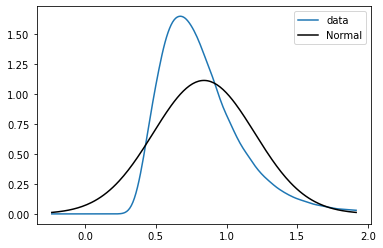

In [11]:
#描述性统计量(对观察期内全部样本数据)
def statistics(close):
    
    mc = np.mean(close)
    stdc = np.std(close)
    print(pd.Series({'mean':mc,'median':np.median(close),'max':np.max(close),'min':np.min(close),'std':stdc,'skewness':stats.skew(close.T),'kurtosis':stats.kurtosis(close.T)}))
    
    #distribution plot
    x = np.linspace(mc-3*stdc,mc+3*stdc,200)
    y = stats.norm.pdf(x,mc,stdc)
    kde = stats.gaussian_kde(close)
    plt.plot(x,kde(x),label='data')
    plt.plot(x,y,color='black',label='Normal')
    plt.legend()
    plt.show()
    
statistics(cvd_latest.values.reshape(1,-1))

mean                   -0.239544
median                 -0.260108
max                      2.28619
min                     -1.31628
std                     0.349327
skewness     [0.569008802103648]
kurtosis    [1.1892643193275738]
dtype: object


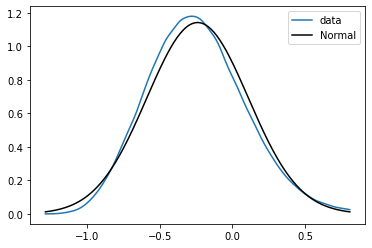

In [12]:
#发现cvd指标类似lognormal分布，取log后再检验统计量
statistics(np.log(cvd_latest.values.reshape(1,-1)))

In [13]:
#group by cvd monthly and label groups
groups_latest = cvd_latest.apply(lambda x: pd.qcut(x,10,labels=list(range(10))),axis=1)
groups_latest.head()

000001 000002 000004 000005 000006 000007 000008 000009 000010  \
2017-02-28      0      6      7      1      6      7      8      2      6   
2017-03-31      0      7      3      1      7      9      8      1      5   
2017-04-30      0      8      5      3      6      9      3      2      5   
2017-05-31      0      4      5      4      7      9      3      4      6   
2017-06-30      0      7      9      5      6      9      3      1      4   

           000011  ... 603969 603979 603986 603988 603989 603993 603996  \
2017-02-28      5  ...      4      6      9      5      1      9      6   
2017-03-31      7  ...      9      5      9      7      1      7      5   
2017-04-30      6  ...      9      4      9      7      1      6      6   
2017-05-31      6  ...      9      3      9      8      1      7      4   
2017-06-30      6  ...      8      3      9      9      1      5      5   

           603997 603998 603999  
2017-02-28      5      5      7  
2017-03-31      6      6      8  
2017-04-30      5      7      6  
2017-05-31      6      7      5  
2017-06-30      6      5      4  

[5 rows x 2708 columns]

In [23]:
#创建分析类
class factor_analysis(object):
    def __init__(self, groups):
        self.groups = groups
    
    #等值加权
    def E_weight(self,ob_t,tt='cvd'):
        ew_re = pd.DataFrame(None,index=ob_t,columns=list(range(10)))
        for i in ob_t:
            ew_re.loc[i,:] = self.Re.loc[i,:].groupby(by=self.groups.loc[i,:]).mean()

        #多空组合
        ew_re['l-h'] = ew_re[0]-ew_re[9]
        
        #cumulative return
        ew_re_cum = ew_re.cumsum()

        #plot
        plt.figure(figsize=(20,24))
        plt.subplot(211)
        for i in ew_re.columns:
            plt.plot(ew_re[i],label='group'+str(i))
        plt.title('equal_weighted_log_return_'+tt)
        plt.legend()

        plt.subplot(212)
        for i in ew_re_cum.columns:
            plt.plot(ew_re_cum[i],label='group'+str(i))
        plt.title('equal_weighted_cumulative_log_return_'+tt)
        plt.legend()
        
        m = np.exp(ew_re_cum.iloc[-1,:].mean())
        def evaluate(df1,rf=0.0384,n=50/12):
            df1 = df1.astype('float')
            
            #CAPM
            X = np.mat(np.stack([np.ones(market_index_return_m[ob_t].shape),market_index_return_m[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            capm_alpha = beta[0][0,0]
            capm_beta = beta[1][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_capm = beta.T/se
            
            #fama 3-factor
            X = np.mat(np.stack([np.ones(market_index_return_m[ob_t].shape),market_index_return_m[ob_t],hml[ob_t],smb[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            fama3_alpha = beta[0][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_fama3 = beta.T/se
            
            #fama 5-factor
            
            X = np.mat(np.stack([np.ones(market_index_return_m[ob_t].shape),market_index_return_m[ob_t],hml[ob_t],smb[ob_t],rmw[ob_t],cma[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            fama5_alpha = beta[0][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_fama5 = beta.T/se
            
            df = df1.cumsum()
            df = np.exp(df.astype('float'))
            Maxdrawdown = -round(((df-df.expanding().max())/df.expanding().max()).min(),3)
            alpha = (df[-1]-m)/n
            sr = round((df[-1]-1-rf*n)/(df.std()*12**0.5),3)
            return(pd.Series({'TotalReturn':round(df[-1]-1,4),'AnnualReturn':round(df[-1]**(1/n)-1,4),'Sharpe':sr,
                              'CAPM Alpha':[round(capm_alpha,4),round(t_value_capm[0,0],4)],'Beta':[round(capm_beta,4),round(t_value_capm[0,1],4)]
                              ,'fama-3-factor alpha':[round(fama3_alpha,4),round(t_value_fama3[0,0],4)]
                              ,'fama-5-factor alpha':[round(fama5_alpha,4),round(t_value_fama5[0,0],4)],'Maxdrawdown':Maxdrawdown}))
        return(ew_re.apply(evaluate,axis=0).T)
    
    #市值加权
    def MC_weight(self,ob_t,tt='cvd'):
        mw_re = pd.DataFrame(None,index=ob_t,columns=list(range(10)))

        #收益率乘以市值再分组加总后，除以各组市值加总即为各组市值加权平均收益，这一方法在迭代上具有优势
        mw = self.Re*self.MarketCap

        for i in ob_t:
            mw_re.loc[i,:] = mw.loc[i,:].groupby(by=self.groups.loc[i,:]).sum()/self.MarketCap.loc[i,:].groupby(by=self.groups.loc[i,:]).sum()

        #多空组合
        mw_re['l-h'] = mw_re[0]-mw_re[9]
        
        #cumulative return
        mw_re_cum = mw_re.cumsum()

        #plot
        plt.figure(figsize=(20,24))
        plt.subplot(211)
        for i in mw_re.columns:
            plt.plot(mw_re[i],label='group'+str(i))
        plt.title('MarketCap_weighted_log_return_'+tt)
        plt.legend()

        plt.subplot(212)
        for i in mw_re_cum.columns:
            plt.plot(mw_re_cum[i],label='group'+str(i))
        plt.title('MarketCap_weighted_cumulative_log_return_'+tt)
        plt.legend()
        
        m = np.exp(mw_re_cum.iloc[-1,:].mean())
        def evaluate(df1,rf=0.0384,n=50/12):
            df1 = df1.astype('float')
            
            #CAPM
            X = np.mat(np.stack([np.ones(market_index_return_m[ob_t].shape),market_index_return_m[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            capm_alpha = beta[0][0,0]
            capm_beta = beta[1][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_capm = beta.T/se
            
            #fama 3-factor
            X = np.mat(np.stack([np.ones(market_index_return_m[ob_t].shape),market_index_return_m[ob_t],hml[ob_t],smb[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            fama3_alpha = beta[0][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_fama3 = beta.T/se
            
            #fama 5-factor
            
            X = np.mat(np.stack([np.ones(market_index_return_m[ob_t].shape),market_index_return_m[ob_t],hml[ob_t],smb[ob_t],rmw[ob_t],cma[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            fama5_alpha = beta[0][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_fama5 = beta.T/se
            
            df = df1.cumsum()
            df = np.exp(df.astype('float'))
            Maxdrawdown = -round(((df-df.expanding().max())/df.expanding().max()).min(),3)
            alpha = (df[-1]-m)/n
            sr = round((df[-1]-1-rf*n)/(df.std()*12**0.5),3)
            return(pd.Series({'TotalReturn':round(df[-1]-1,4),'AnnualReturn':round(df[-1]**(1/n)-1,4),'Sharpe':sr,
                              'CAPM Alpha':[round(capm_alpha,4),round(t_value_capm[0,0],4)],'Beta':[round(capm_beta,4),round(t_value_capm[0,1],4)]
                              ,'fama-3-factor alpha':[round(fama3_alpha,4),round(t_value_fama3[0,0],4)]
                              ,'fama-5-factor alpha':[round(fama5_alpha,4),round(t_value_fama5[0,0],4)],'Maxdrawdown':Maxdrawdown}))

        return(mw_re.apply(evaluate,axis=0).T)


TotalReturn AnnualReturn Sharpe          CAPM Alpha              Beta  \
0        0.1167       0.0269 -0.098    [0.0018, 0.2453]   [0.224, 1.5509]   
1       -0.1037      -0.0259 -0.793   [-0.0026, -0.351]   [0.1838, 1.259]   
2       -0.1392      -0.0353 -0.885   [-0.0033, -0.438]  [0.1672, 1.0969]   
3       -0.2361      -0.0626  -1.15  [-0.0058, -0.7184]  [0.1846, 1.1491]   
4       -0.3025      -0.0828  -1.27  [-0.0076, -0.9251]  [0.2019, 1.2236]   
5       -0.3265      -0.0905 -1.244  [-0.0083, -0.9855]   [0.2019, 1.194]   
6       -0.3478      -0.0975 -1.347   [-0.009, -1.0441]  [0.2059, 1.1961]   
7       -0.4547      -0.1354 -1.409  [-0.0125, -1.4623]   [0.189, 1.1015]   
8       -0.4586      -0.1369 -1.404  [-0.0126, -1.4787]  [0.1594, 0.9332]   
9       -0.6417      -0.2183 -1.295   [-0.021, -2.3015]   [0.2154, 1.179]   
l-h      2.1166       0.3137    0.9    [0.0227, 4.4737]  [0.0086, 0.0843]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0      [0.0027, 0.3486]    [0.0051, 0.5739]       0.364  
1      [0.0018, 0.2304]    [0.0045, 0.5193]       0.352  
2      [0.0024, 0.3102]      [0.0049, 0.55]       0.382  
3      [0.0018, 0.2304]    [0.0044, 0.4922]       0.407  
4    [-0.0006, -0.0682]      [0.0033, 0.36]       0.442  
5    [-0.0009, -0.1089]    [0.0041, 0.4292]       0.472  
6    [-0.0001, -0.0078]    [0.0045, 0.4825]       0.455  
7    [-0.0039, -0.4718]    [0.0021, 0.2227]       0.517  
8    [-0.0045, -0.5375]    [0.0012, 0.1298]       0.535  
9    [-0.0121, -1.3452]  [-0.0052, -0.5305]       0.656  
l-h    [0.0148, 3.7502]    [0.0104, 2.5528]       0.079

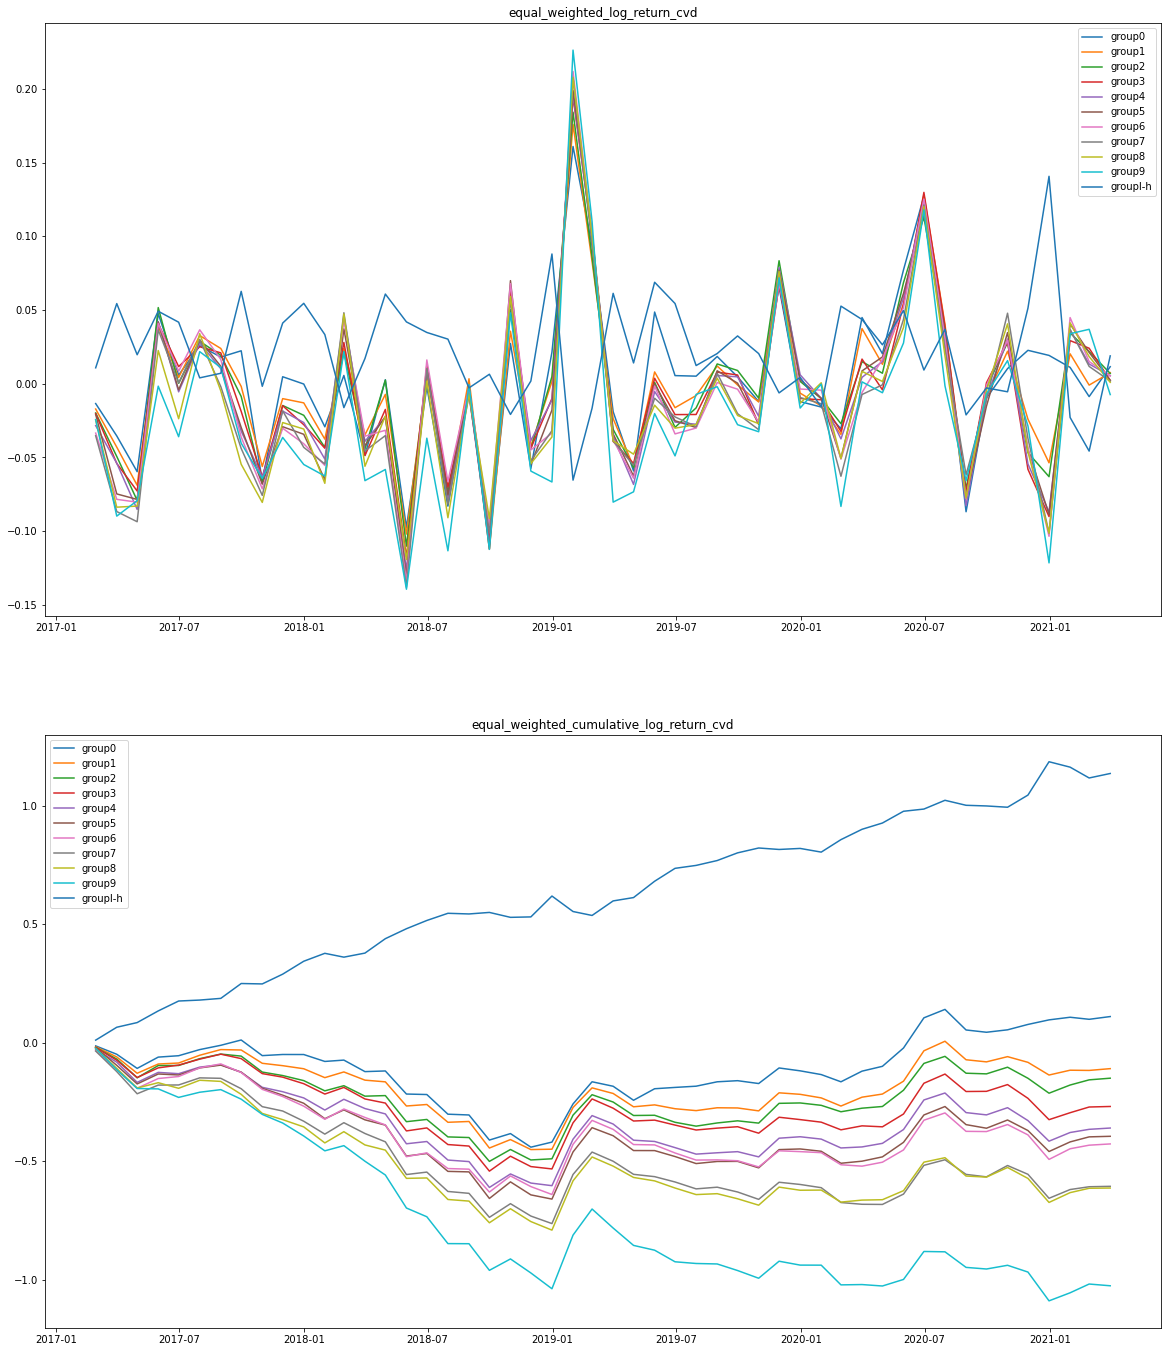

In [24]:
#传入参数
cvd_ana = factor_analysis(groups_latest)
cvd_ana.Re = Re_latest
cvd_ana.MarketCap = MarketCap_latest

#等值加权
cvd_ana.E_weight(ob_t = ob_t,tt='cvd')

TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0        0.6084       0.1208   0.75    [0.0092, 1.4064]    [0.1352, 1.0259]   
1        0.2004       0.0448  0.101    [0.0035, 0.5406]     [0.0536, 0.407]   
2       -0.0052      -0.0013 -0.556  [-0.0002, -0.0376]    [0.0678, 0.5313]   
3       -0.0619      -0.0152 -0.679  [-0.0015, -0.2186]    [0.1359, 0.9568]   
4       -0.1708       -0.044 -1.234  [-0.0039, -0.5135]    [0.0989, 0.6419]   
5       -0.2125      -0.0557 -1.102  [-0.0049, -0.6312]    [0.0788, 0.5025]   
6       -0.3341       -0.093 -1.119  [-0.0084, -1.0516]    [0.1511, 0.9393]   
7        -0.383      -0.1094 -1.228      [-0.01, -1.19]    [0.1576, 0.9377]   
8       -0.3665      -0.1038 -1.283  [-0.0093, -1.1592]    [0.0872, 0.5417]   
9       -0.6968       -0.249 -1.238  [-0.0243, -2.8149]    [0.2294, 1.3232]   
l-h      4.3044       0.4925  1.034    [0.0336, 4.5868]  [-0.0942, -0.6414]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0      [0.0062, 0.9278]    [0.0051, 0.6683]       0.295  
1      [0.0038, 0.5475]    [0.0034, 0.4331]       0.255  
2       [0.002, 0.2965]    [0.0015, 0.1877]       0.302  
3      [0.0025, 0.3336]    [0.0037, 0.4513]       0.327  
4    [-0.0001, -0.0066]       [0.003, 0.33]       0.295  
5    [-0.0003, -0.0355]     [0.003, 0.3332]       0.349  
6    [-0.0023, -0.2823]      [0.0014, 0.15]       0.439  
7    [-0.0027, -0.3128]    [0.0025, 0.2659]       0.451  
8     [-0.003, -0.3596]    [0.0007, 0.0791]       0.436  
9    [-0.0171, -1.9302]  [-0.0127, -1.2987]       0.694  
l-h    [0.0233, 3.7996]    [0.0178, 2.7884]        0.15

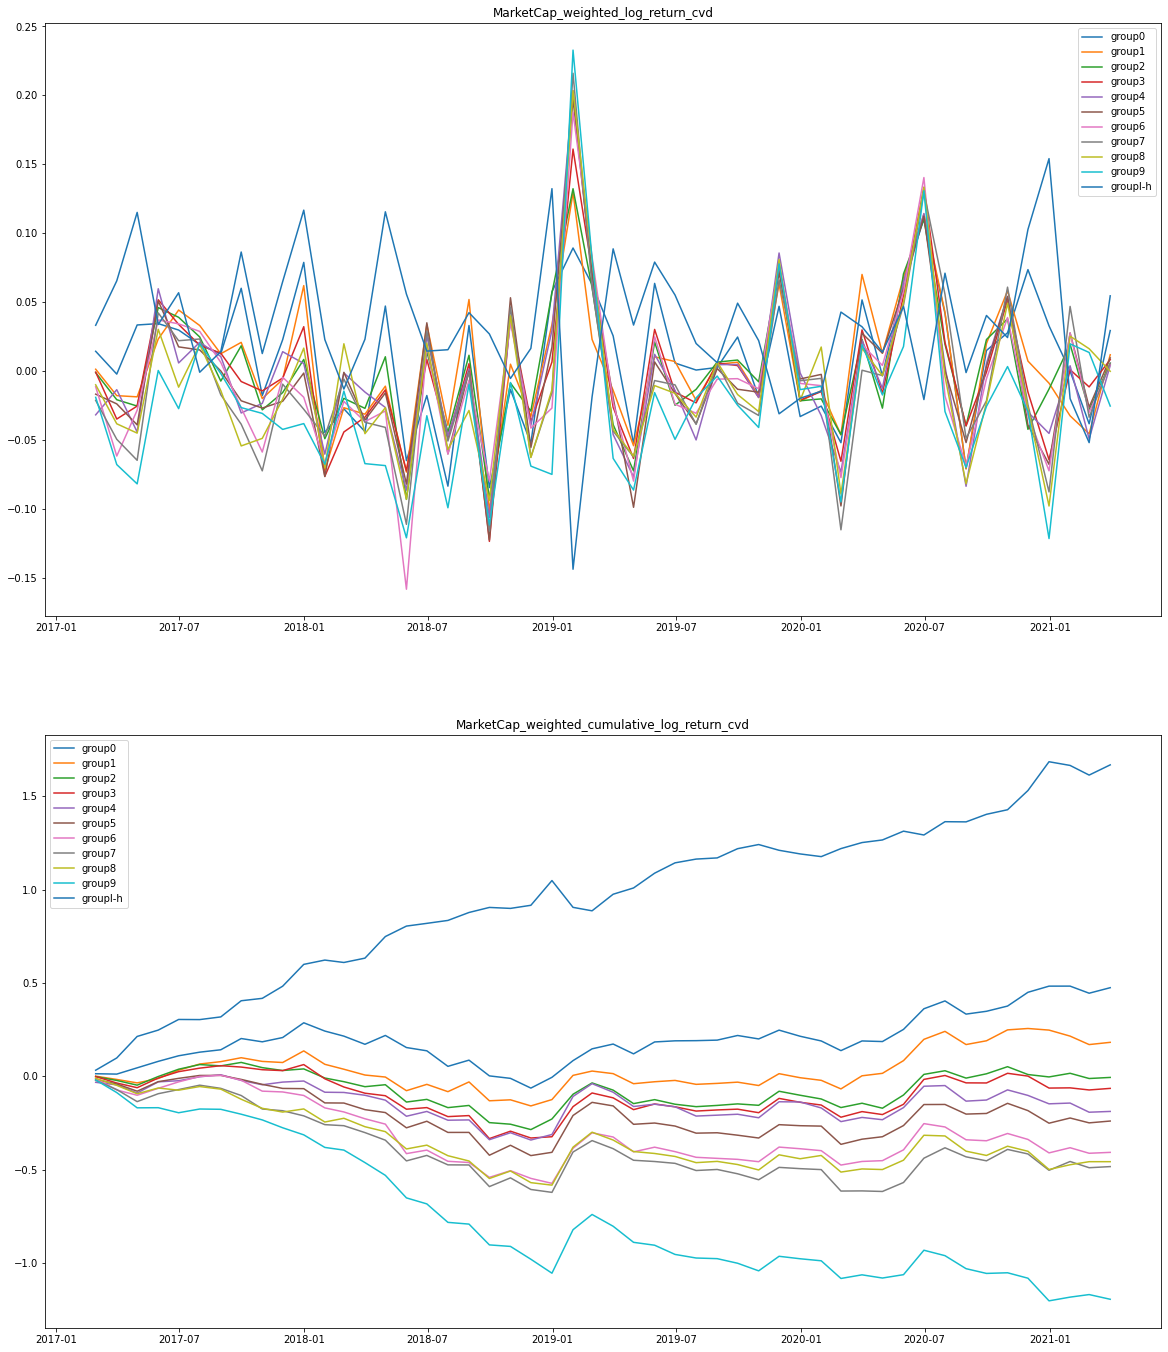

In [25]:
#市值加权
cvd_ana.MC_weight(ob_t = ob_t,tt='cvd')

In [58]:
#测试不同时期是否具有相同指标，选取再往前50个观察日
new_obt = ClosePrice.index[-101:-51]
Re_test,MarketCap_test,cvd_new = get_observations(Re,MarketCap,cvd,new_obt)
print('start_date ',new_obt[0],'\nend_date ',new_obt[-1])
cma.fillna(method='ffill',inplace = True)

#分组
groups_test = cvd_new.apply(lambda x: pd.qcut(x,10,labels=list(range(10))),axis=1)
groups_test.head()

start_date  2012-12-31 00:00:00 
end_date  2017-01-31 00:00:00


000001 000004 000005 000006 000008 000009 000010 000011 000012  \
2012-12-31      2      9      6      7      5      1      8      4      2   
2013-01-31      8      8      8      8      6      1      9      7      1   
2013-02-28      8      8      8      7      7      1      9      6      1   
2013-03-31      6      8      8      6      7      7      9      7      0   
2013-04-30      4      8      8      5      8      5      9      6      0   

           000014  ... 601996 601998 601999 603000 603001 603002 603123  \
2012-12-31      2  ...      9      4      8      0      2      7      4   
2013-01-31      5  ...      8      6      8      0      3      5      2   
2013-02-28      4  ...      7      5      7      0      2      4      1   
2013-03-31      6  ...      5      8      7      0      2      4      3   
2013-04-30      6  ...      3      8      3      0      0      6      5   

           603128 603333 603366  
2012-12-31      7      5      1  
2013-01-31      8      4      0  
2013-02-28      7      4      0  
2013-03-31      8      6      0  
2013-04-30      8      7      0  

[5 rows x 2150 columns]

TotalReturn AnnualReturn Sharpe          CAPM Alpha               Beta  \
0         1.095       0.1942  0.578    [0.0107, 0.7943]   [0.4328, 2.5487]   
1        1.4022       0.2341  0.598    [0.0135, 1.0163]   [0.4314, 2.5857]   
2        1.1266       0.1985  0.573    [0.0111, 0.8247]   [0.4184, 2.4578]   
3        1.4375       0.2384  0.603    [0.0138, 1.0296]   [0.4247, 2.5131]   
4        1.3268       0.2247  0.586    [0.0128, 0.9483]   [0.4294, 2.5171]   
5        1.4955       0.2454  0.593    [0.0145, 1.0885]   [0.4012, 2.3897]   
6        1.1566       0.2026  0.535    [0.0112, 0.8479]   [0.4396, 2.6358]   
7        1.1825        0.206  0.542    [0.0115, 0.8745]   [0.4377, 2.6465]   
8        1.5645       0.2536  0.589    [0.0146, 1.1211]   [0.4471, 2.7219]   
9        1.8253       0.2831  0.556    [0.0158, 1.1939]   [0.5258, 3.1515]   
l-h     -0.2585      -0.0693 -0.988  [-0.0051, -0.9788]  [-0.093, -1.4156]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0      [-0.01, -0.6645]    [0.0031, 0.1952]       0.413  
1    [-0.0081, -0.5539]    [0.0059, 0.3959]       0.404  
2    [-0.0095, -0.6347]    [0.0054, 0.3559]       0.437  
3    [-0.0072, -0.4871]    [0.0082, 0.5589]       0.406  
4    [-0.0067, -0.4456]    [0.0087, 0.5788]       0.425  
5     [-0.005, -0.3359]    [0.0102, 0.6918]       0.423  
6     [-0.0084, -0.566]    [0.0072, 0.4882]       0.467  
7    [-0.0085, -0.5761]    [0.0071, 0.4889]       0.445  
8    [-0.0047, -0.3221]    [0.0095, 0.6373]       0.435  
9    [-0.0082, -0.5715]    [0.0032, 0.2174]       0.466  
l-h  [-0.0018, -0.2823]  [-0.0002, -0.0255]       0.409

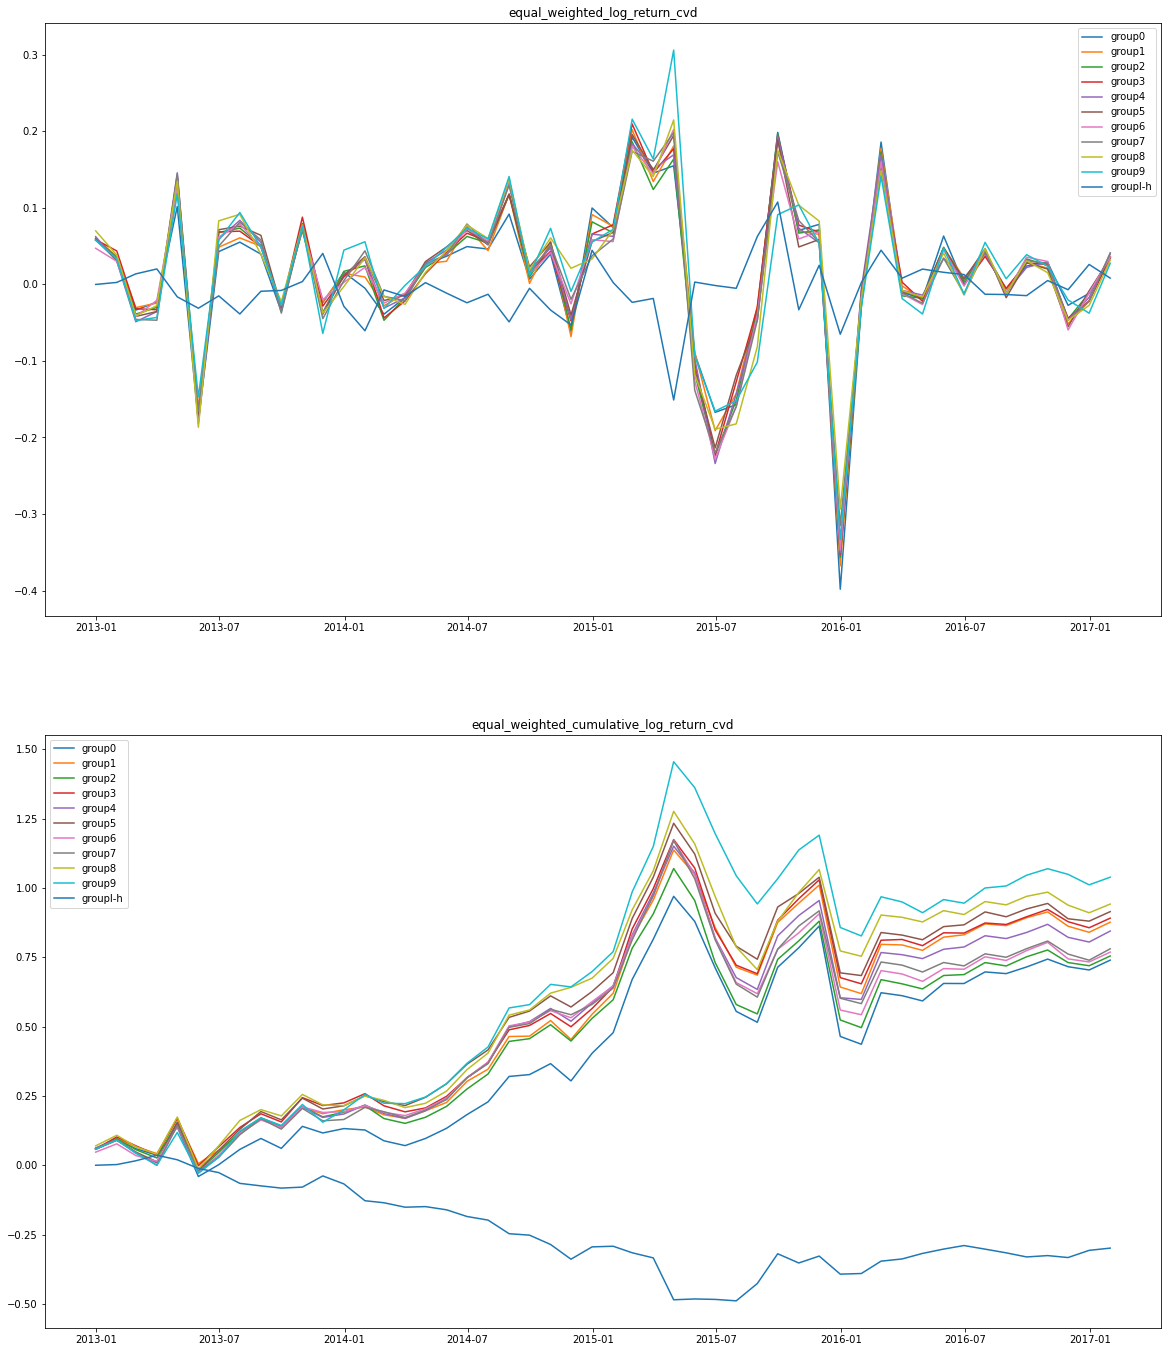

In [59]:
#传入参数
cvd_test = factor_analysis(groups_test)
cvd_test.Re = Re_test
cvd_test.MarketCap = MarketCap_test

#等值加权
cvd_test.E_weight(ob_t = new_obt,tt='cvd')

TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0        0.3316       0.0711  0.198     [0.002, 0.1666]    [0.3985, 2.6766]   
1        0.4572       0.0946  0.283    [0.0043, 0.3955]    [0.3395, 2.4622]   
2        0.2875       0.0625  0.145    [0.0016, 0.1394]    [0.3705, 2.6262]   
3         0.593       0.1182  0.392    [0.0058, 0.5055]    [0.3767, 2.6242]   
4        0.3837       0.0811  0.234      [0.0031, 0.26]    [0.3652, 2.4701]   
5        0.5001       0.1022  0.251    [0.0049, 0.4049]    [0.3416, 2.2463]   
6        0.4103        0.086  0.214    [0.0027, 0.2222]    [0.4463, 2.9502]   
7        0.7664       0.1463  0.399    [0.0076, 0.6291]    [0.3994, 2.6208]   
8        0.3313       0.0711  0.168    [0.0023, 0.1917]    [0.3654, 2.4406]   
9       -0.0298      -0.0072 -0.132  [-0.0052, -0.3794]    [0.4851, 2.8209]   
l-h      0.3725        0.079   0.29    [0.0071, 0.7691]  [-0.0866, -0.7398]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0    [-0.0032, -0.2245]    [0.0048, 0.3113]       0.441  
1      [0.0011, 0.0862]    [0.0106, 0.7575]        0.38  
2    [-0.0032, -0.2413]      [0.01, 0.7349]       0.475  
3     [-0.001, -0.0753]    [0.0116, 0.8401]       0.448  
4       [0.005, 0.3591]    [0.0181, 1.2908]       0.469  
5       [0.006, 0.4111]      [0.02, 1.3579]       0.495  
6      [0.0033, 0.2284]    [0.0186, 1.2661]       0.508  
7      [0.0071, 0.4831]    [0.0222, 1.5434]       0.521  
8      [0.0059, 0.4114]    [0.0188, 1.2885]       0.472  
9    [-0.0052, -0.3115]     [0.011, 0.6697]       0.683  
l-h     [0.002, 0.1858]  [-0.0062, -0.5608]       0.361

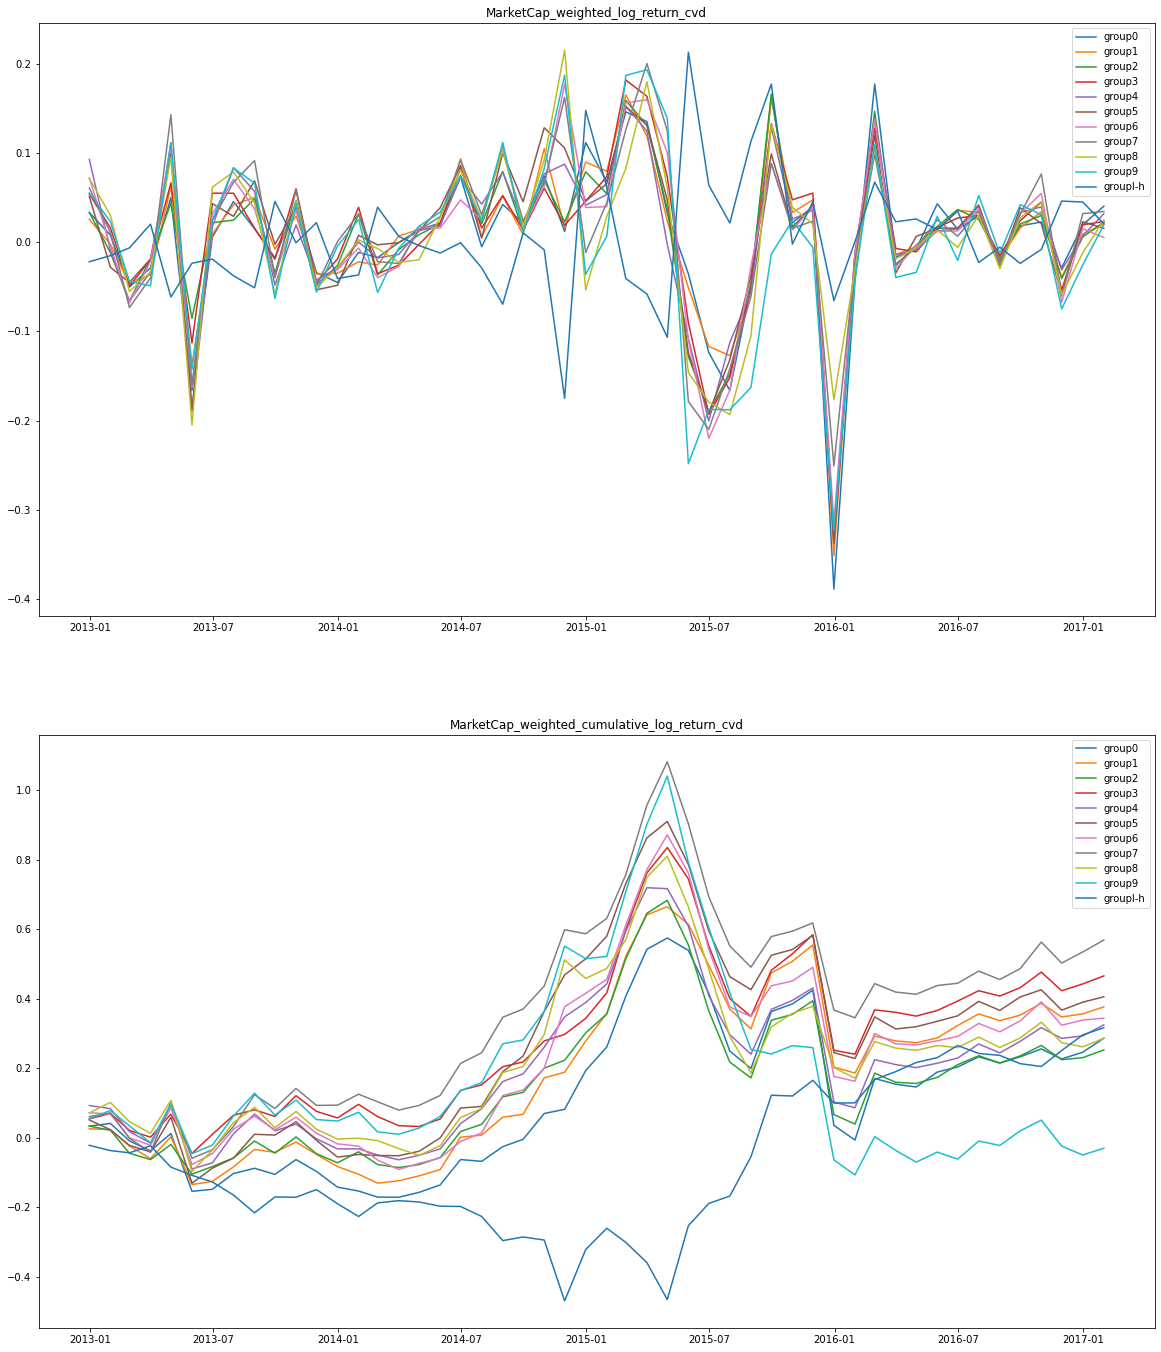

In [60]:
#市值加权
cvd_test.MC_weight(ob_t = new_obt,tt='cvd')

In [61]:
#选取不同行业
industry = pd.DataFrame(data['WIND_IDX_INDCLS2_MEMBER'],index = tic,columns=dates).T

In [62]:
industry.loc[ob_t[0],:].value_counts()

0         1250
882102     664
882101     512
882120     247
882106     191
882114     185
882119     181
882111     155
882118     141
882105     125
882123      94
882104      93
882108      75
882100      73
882109      69
882103      61
882113      53
882121      53
882116      44
882107      40
882115      25
882110      21
882112       7
882117       5
882122       4
Name: 2017-02-28 00:00:00, dtype: int64

In [63]:
#我们选取wind行业标码为 882101(材料) 882102(资本货物) 882120（技术硬件与设备)的行业
ind_882101 = industry.loc[ob_t[0]][industry.loc[ob_t[0]]==882101].index
ind_882102 = industry.loc[ob_t[0]][industry.loc[ob_t[0]]==882102].index
ind_882120 = industry.loc[ob_t[0]][industry.loc[ob_t[0]]==882120].index

In [64]:
def get_observations_ind(Re,MarketCap,factors,ob_t,tics):    
    #dropna and infs
    factor = factors.loc[ob_t,tics].copy()
    #处理极端数据
    factor[factor>10]=np.NaN
    factor[factor==0]=np.NaN
    factor.dropna(axis=1,inplace=True)
    Re = Re.loc[ob_t,factor.columns]
    MarketCap = MarketCap.resample('M').last().loc[ob_t,factor.columns]
    return(Re,MarketCap,factor)

#数据处理
Re_ind_882101,MarketCap_ind_882101,cvd_ind_882101 = get_observations_ind(Re,MarketCap,cvd,ob_t,ind_882101)
Re_ind_882102,MarketCap_ind_882102,cvd_ind_882102 = get_observations_ind(Re,MarketCap,cvd,ob_t,ind_882102)
Re_ind_882120,MarketCap_ind_882120,cvd_ind_882120 = get_observations_ind(Re,MarketCap,cvd,ob_t,ind_882120)
groups_ind_882101 = cvd_ind_882101.apply(lambda x: pd.qcut(x,10,labels=list(range(10))),axis=1)
groups_ind_882102 = cvd_ind_882102.apply(lambda x: pd.qcut(x,10,labels=list(range(10))),axis=1)
groups_ind_882120 = cvd_ind_882120.apply(lambda x: pd.qcut(x,10,labels=list(range(10))),axis=1)
print('start_date ',ob_t[0],'\nend_date ',ob_t[-1])

start_date  2017-02-28 00:00:00 
end_date  2021-03-31 00:00:00


In [65]:
#传入数据
ind_882101_test = factor_analysis(groups_ind_882101)
ind_882101_test.Re = Re_ind_882101
ind_882101_test.MarketCap = MarketCap_ind_882101

ind_882102_test = factor_analysis(groups_ind_882102)
ind_882102_test.Re = Re_ind_882102
ind_882102_test.MarketCap = MarketCap_ind_882102

ind_882120_test = factor_analysis(groups_ind_882120)
ind_882120_test.Re = Re_ind_882120
ind_882120_test.MarketCap = MarketCap_ind_882120


TotalReturn AnnualReturn Sharpe          CAPM Alpha              Beta  \
0        0.2243       0.0498   0.11    [0.0035, 0.3881]  [0.2799, 1.5492]   
1       -0.0677      -0.0167 -0.544  [-0.0018, -0.2238]  [0.1956, 1.2196]   
2       -0.0505      -0.0124  -0.56  [-0.0014, -0.1762]  [0.2069, 1.2557]   
3        0.0001            0 -0.464  [-0.0004, -0.0527]  [0.2208, 1.3321]   
4        -0.141      -0.0358 -0.781   [-0.0034, -0.404]   [0.1819, 1.077]   
5       -0.1709       -0.044 -0.822   [-0.004, -0.4559]  [0.1297, 0.7354]   
6       -0.3375      -0.0941 -1.177  [-0.0086, -0.9613]     [0.1607, 0.9]   
7       -0.3698      -0.1049 -1.227  [-0.0096, -1.1131]   [0.162, 0.9403]   
8       -0.4405      -0.1301 -1.364  [-0.0119, -1.3423]  [0.1288, 0.7256]   
9       -0.5088      -0.1569   -1.2  [-0.0144, -1.6407]  [0.1163, 0.6578]   
l-h      1.4926       0.2451  0.932    [0.0179, 2.9204]  [0.1637, 1.3275]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0      [0.0066, 0.6957]    [0.0072, 0.6624]       0.423  
1      [0.0037, 0.4428]    [0.0054, 0.5611]       0.415  
2      [0.0044, 0.5086]    [0.0056, 0.5759]       0.392  
3      [0.0072, 0.8655]    [0.0085, 0.8917]       0.352  
4      [0.0041, 0.4732]    [0.0074, 0.7615]       0.401  
5      [0.0046, 0.5184]    [0.0085, 0.8475]       0.433  
6      [0.0001, 0.0093]    [0.0064, 0.6472]       0.495  
7    [-0.0007, -0.0855]     [0.0053, 0.555]       0.454  
8    [-0.0029, -0.3357]     [0.0023, 0.238]       0.522  
9    [-0.0065, -0.7296]  [-0.0026, -0.2583]       0.534  
l-h    [0.0131, 2.2326]    [0.0098, 1.4968]       0.095

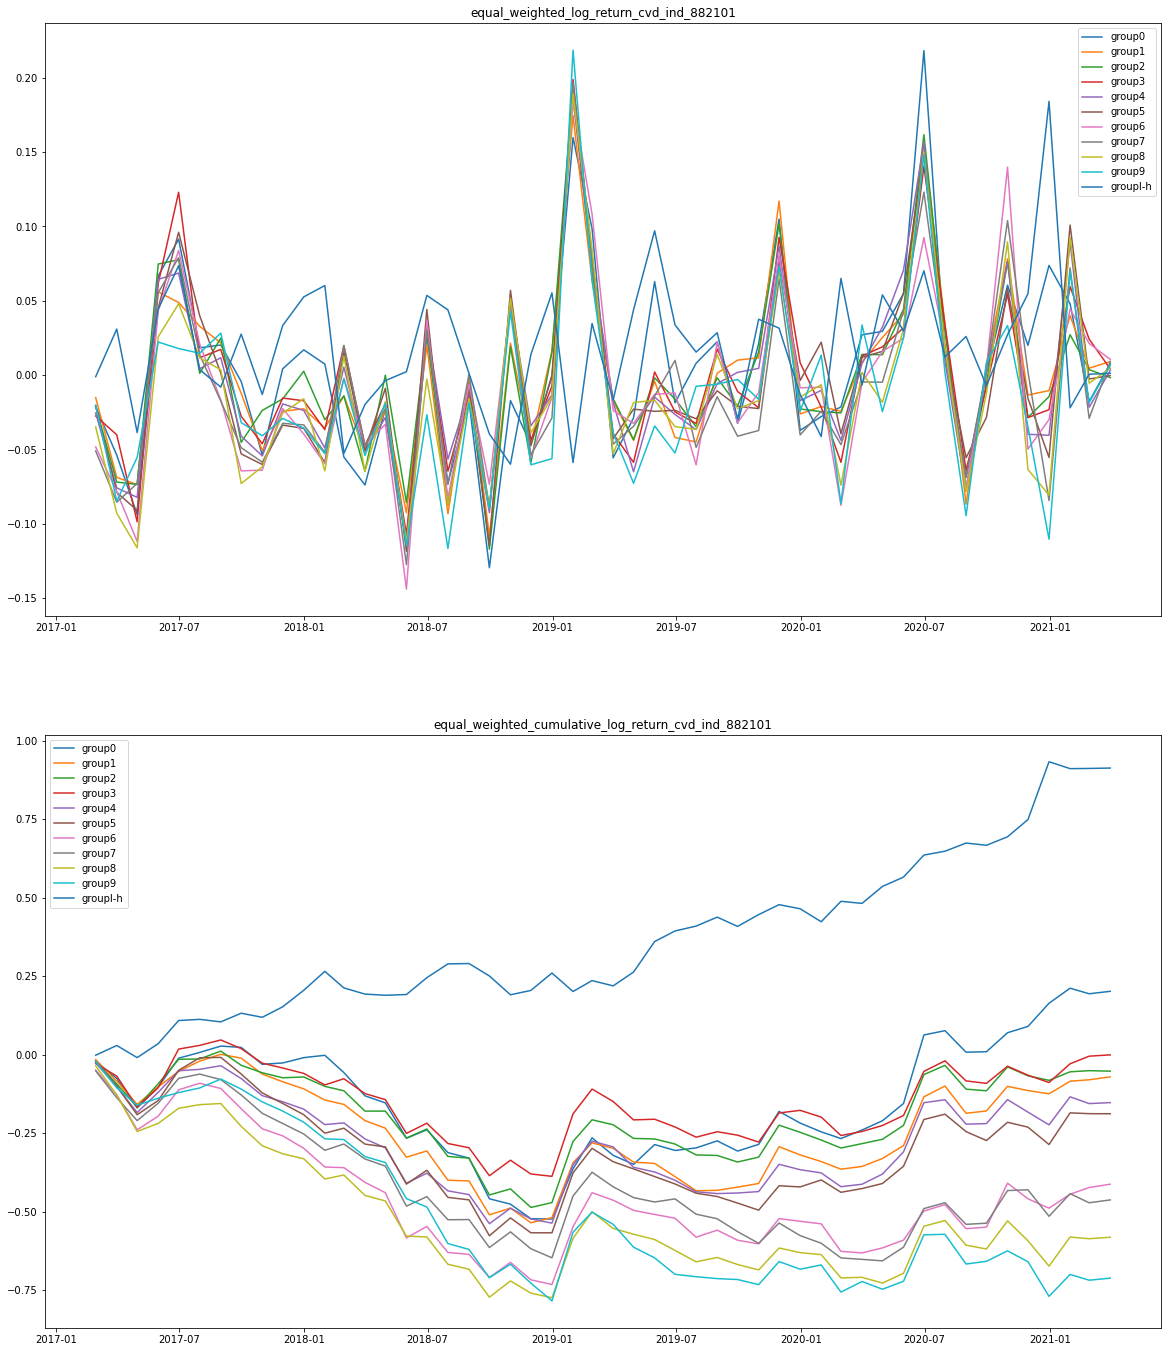

In [66]:
#882101等值加权
ind_882101_test.E_weight(ob_t = ob_t,tt='cvd_ind_882101')

TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0        0.7929       0.1504  0.726    [0.0114, 1.1543]    [0.1496, 0.7559]   
1        0.1393       0.0318  -0.04    [0.0023, 0.2711]    [0.1724, 1.0273]   
2        0.2215       0.0492  0.117    [0.0035, 0.3813]    [0.2441, 1.3181]   
3       -0.0613      -0.0151 -0.568  [-0.0015, -0.1776]    [0.1158, 0.6864]   
4        0.0378       0.0089 -0.264    [0.0004, 0.0443]     [0.165, 0.8746]   
5        -0.081      -0.0201 -0.545  [-0.0018, -0.1827]    [0.0425, 0.2184]   
6       -0.3477      -0.0975 -1.103  [-0.0087, -0.9146]    [0.0653, 0.3429]   
7       -0.2616      -0.0702 -0.961  [-0.0062, -0.6444]    [0.0531, 0.2765]   
8       -0.5702      -0.1835 -1.194   [-0.017, -1.7471]     [0.076, 0.3882]   
9       -0.5985      -0.1967 -1.167  [-0.0188, -1.9822]    [0.2873, 1.5079]   
l-h      3.4653       0.4321  1.054    [0.0302, 3.7616]  [-0.1377, -0.8548]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0      [0.0123, 1.2256]    [0.0095, 0.8356]       0.382  
1       [0.0054, 0.617]    [0.0068, 0.6805]       0.372  
2       [0.0087, 0.945]    [0.0095, 0.9105]       0.405  
3      [0.0019, 0.2149]    [0.0044, 0.4423]       0.333  
4      [0.0045, 0.4532]     [0.0085, 0.773]       0.386  
5      [0.0048, 0.4733]     [0.0103, 0.909]       0.436  
6    [-0.0027, -0.2689]    [0.0039, 0.3561]       0.471  
7       [0.002, 0.2044]    [0.0068, 0.6267]       0.437  
8     [-0.011, -1.0719]   [-0.005, -0.4363]       0.594  
9    [-0.0135, -1.3414]   [-0.0152, -1.343]       0.606  
l-h    [0.0257, 3.2646]    [0.0248, 2.7814]       0.109

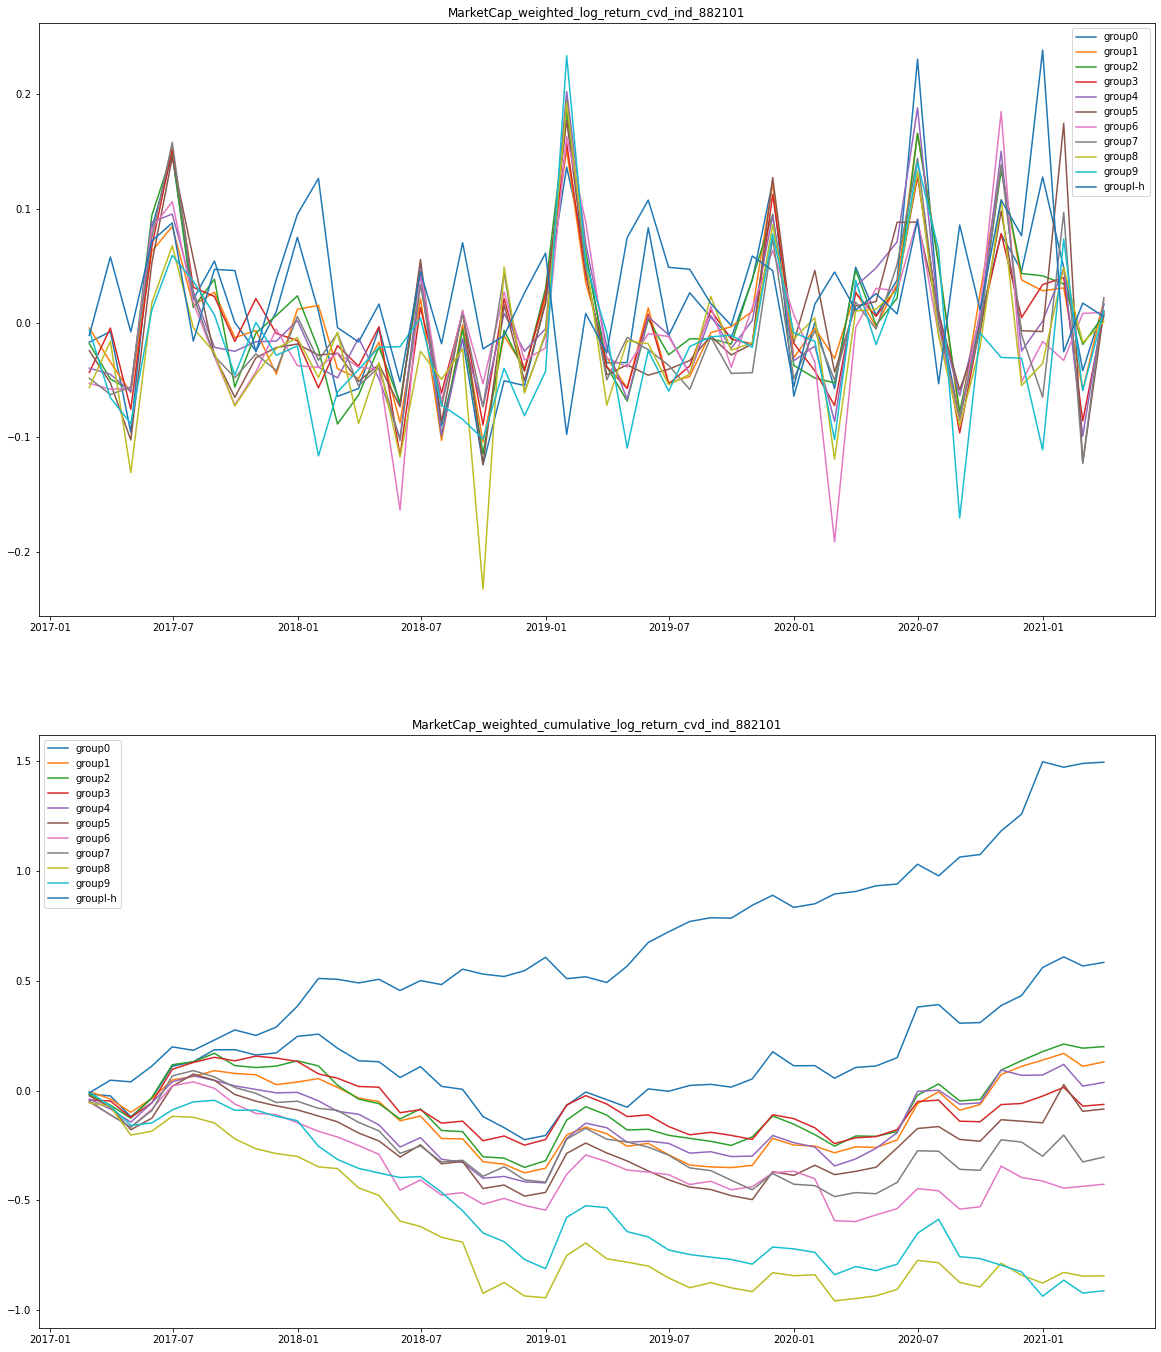

In [67]:
#882101市值加权
ind_882101_test.MC_weight(ob_t = ob_t,tt='cvd_ind_882101')

TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0       -0.1116       -0.028 -0.702  [-0.0028, -0.3572]    [0.2033, 1.3064]   
1       -0.1396      -0.0355 -0.884  [-0.0033, -0.4279]    [0.1665, 1.0636]   
2       -0.1934      -0.0503 -0.992  [-0.0048, -0.5901]    [0.2476, 1.5209]   
3       -0.3369      -0.0939 -1.134  [-0.0086, -1.0039]    [0.2146, 1.2423]   
4       -0.3318      -0.0922 -1.172  [-0.0085, -0.9593]    [0.1989, 1.1243]   
5       -0.4073       -0.118 -1.383  [-0.0109, -1.2573]    [0.2273, 1.3053]   
6       -0.3699      -0.1049 -1.322   [-0.0096, -1.103]    [0.1956, 1.1174]   
7       -0.4902      -0.1493 -1.456  [-0.0138, -1.4917]    [0.1409, 0.7616]   
8         -0.44      -0.1299 -1.349   [-0.012, -1.2795]    [0.2049, 1.0884]   
9       -0.6722      -0.2348 -1.175  [-0.0228, -2.4252]    [0.2281, 1.2114]   
l-h      1.7098       0.2703  0.833      [0.02, 3.8925]  [-0.0248, -0.2411]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0    [-0.0003, -0.0306]    [0.0045, 0.4808]       0.406  
1      [0.0041, 0.5199]    [0.0076, 0.8657]       0.422  
2      [0.0033, 0.4236]    [0.0058, 0.6445]       0.437  
3    [-0.0008, -0.0922]      [0.0016, 0.17]       0.488  
4     [-0.0012, -0.137]    [0.0055, 0.5745]        0.51  
5    [-0.0024, -0.2887]    [0.0033, 0.3483]       0.513  
6    [-0.0002, -0.0288]    [0.0033, 0.3564]       0.503  
7    [-0.0043, -0.4868]    [0.0021, 0.2161]       0.552  
8    [-0.0035, -0.3859]     [0.0024, 0.236]       0.544  
9     [-0.0137, -1.466]  [-0.0073, -0.7066]       0.693  
l-h    [0.0135, 2.8042]    [0.0118, 2.2162]       0.057

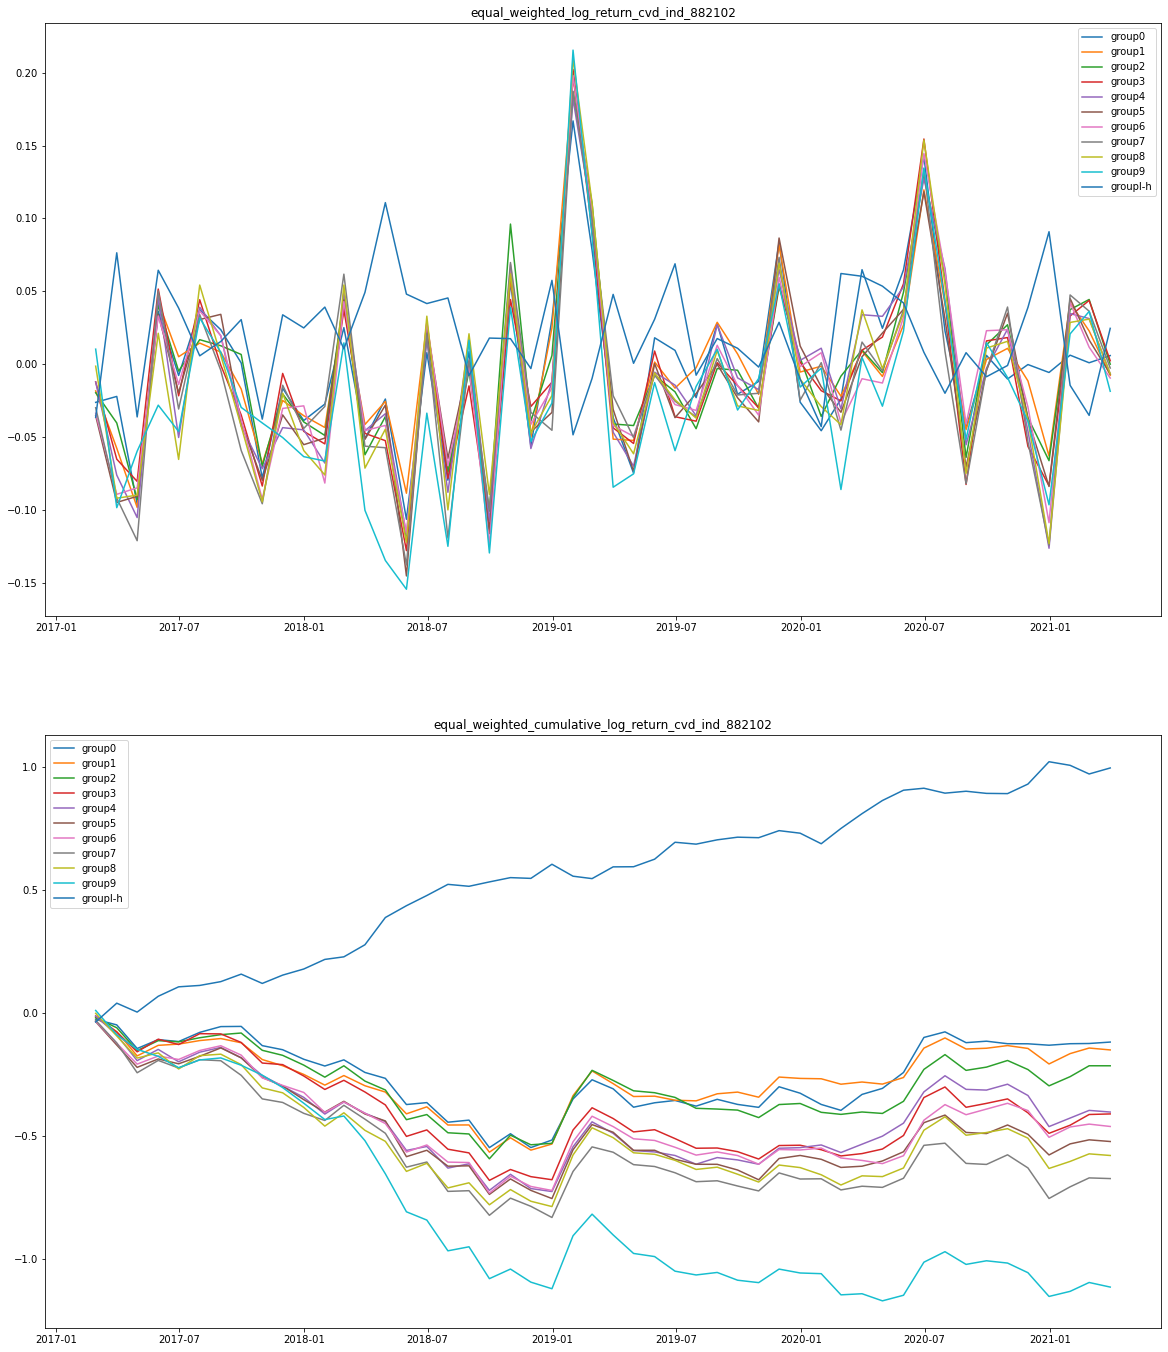

In [68]:
#882102等值加权
ind_882102_test.E_weight(ob_t = ob_t,tt='cvd_ind_882102')

TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0       -0.0174      -0.0042  -0.36  [-0.0007, -0.0777]    [0.1588, 0.9241]   
1        0.0197       0.0047  -0.38    [0.0002, 0.0214]    [0.1211, 0.8524]   
2       -0.1405      -0.0357 -0.905   [-0.0034, -0.526]    [0.1893, 1.4587]   
3       -0.4712      -0.1418 -1.215  [-0.0129, -1.7104]    [0.0637, 0.4217]   
4       -0.2643       -0.071 -1.126  [-0.0065, -0.7889]    [0.1681, 1.0212]   
5       -0.3193      -0.0882 -1.186  [-0.0079, -0.9909]    [0.1183, 0.7366]   
6       -0.3075      -0.0844 -1.134  [-0.0077, -0.9799]    [0.1949, 1.2299]   
7       -0.4195      -0.1224 -1.415  [-0.0112, -1.2858]    [0.1806, 1.0302]   
8       -0.4298      -0.1261 -1.299  [-0.0116, -1.2492]    [0.1816, 0.9752]   
9       -0.6887      -0.2443  -1.08  [-0.0239, -2.5268]    [0.2641, 1.3934]   
l-h      2.1567       0.3177  0.854    [0.0232, 3.2295]  [-0.1053, -0.7306]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0    [-0.0026, -0.2782]    [0.0043, 0.4233]        0.43  
1      [0.0045, 0.6061]    [0.0068, 0.8245]       0.331  
2      [0.0023, 0.3494]     [0.0033, 0.439]       0.355  
3    [-0.0091, -1.1433]   [-0.007, -0.7958]       0.476  
4    [-0.0012, -0.1375]    [0.0052, 0.5545]       0.422  
5    [-0.0014, -0.1725]    [0.0028, 0.3019]        0.41  
6       [0.0011, 0.146]     [0.005, 0.5729]       0.419  
7    [-0.0047, -0.5241]    [0.0008, 0.0796]       0.509  
8    [-0.0048, -0.5058]    [0.0009, 0.0822]       0.531  
9    [-0.0154, -1.6156]   [-0.0093, -0.901]       0.699  
l-h    [0.0128, 1.9948]    [0.0136, 1.8637]       0.132

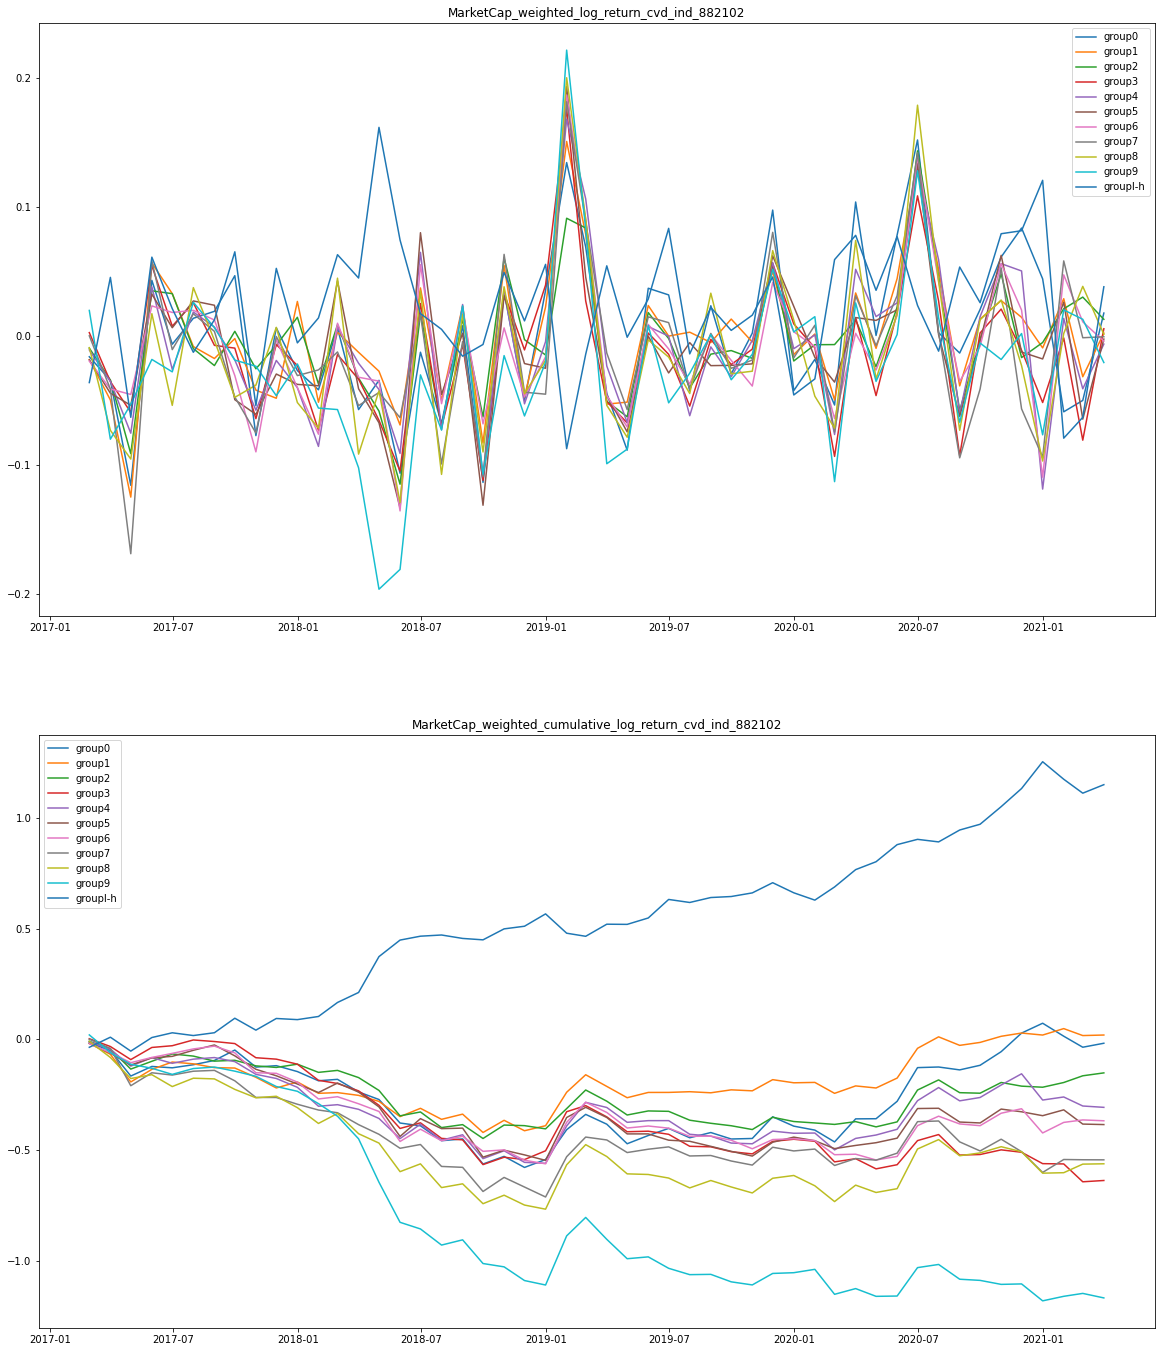

In [69]:
#882102市值加权
ind_882102_test.MC_weight(ob_t = ob_t,tt='cvd_ind_882102')

TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0         0.297       0.0644  0.183    [0.0051, 0.4224]    [0.0659, 0.2736]   
1        -0.184      -0.0476  -0.85   [-0.004, -0.3969]  [-0.0106, -0.0516]   
2        0.0073       0.0018  -0.29   [-0.0005, -0.055]    [0.3308, 1.7866]   
3       -0.3053      -0.0837 -1.009   [-0.0074, -0.671]    [0.0561, 0.2536]   
4       -0.0955      -0.0238 -0.669  [-0.0021, -0.2046]    [0.0718, 0.3406]   
5       -0.3195      -0.0883  -1.22  [-0.0079, -0.8074]     [0.125, 0.6329]   
6        -0.435      -0.1281 -1.349  [-0.0116, -1.1031]    [0.0838, 0.3977]   
7       -0.2584      -0.0692 -1.469  [-0.0062, -0.5656]    [0.0963, 0.4397]   
8       -0.5267      -0.1643 -1.519  [-0.0151, -1.5511]    [0.0837, 0.4278]   
9       -0.6489      -0.2222 -1.478  [-0.0211, -1.8261]     [0.0779, 0.336]   
l-h      2.6944       0.3684   0.91    [0.0262, 2.6825]  [-0.0119, -0.0611]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0      [0.0018, 0.1418]    [0.0078, 0.5337]       0.456  
1    [-0.0008, -0.0769]     [0.005, 0.4187]       0.395  
2      [0.0037, 0.3762]    [0.0139, 1.3071]       0.476  
3    [-0.0001, -0.0088]    [0.0076, 0.6238]       0.492  
4      [0.0065, 0.6145]    [0.0133, 1.1275]       0.389  
5    [-0.0014, -0.1389]    [0.0061, 0.5596]       0.505  
6    [-0.0021, -0.2045]     [0.007, 0.6123]       0.543  
7       [0.0039, 0.376]    [0.0138, 1.2539]        0.44  
8    [-0.0063, -0.6611]    [0.0017, 0.1623]       0.519  
9    [-0.0117, -1.0105]  [-0.0009, -0.0729]       0.643  
l-h    [0.0135, 1.6257]    [0.0087, 0.9331]       0.213

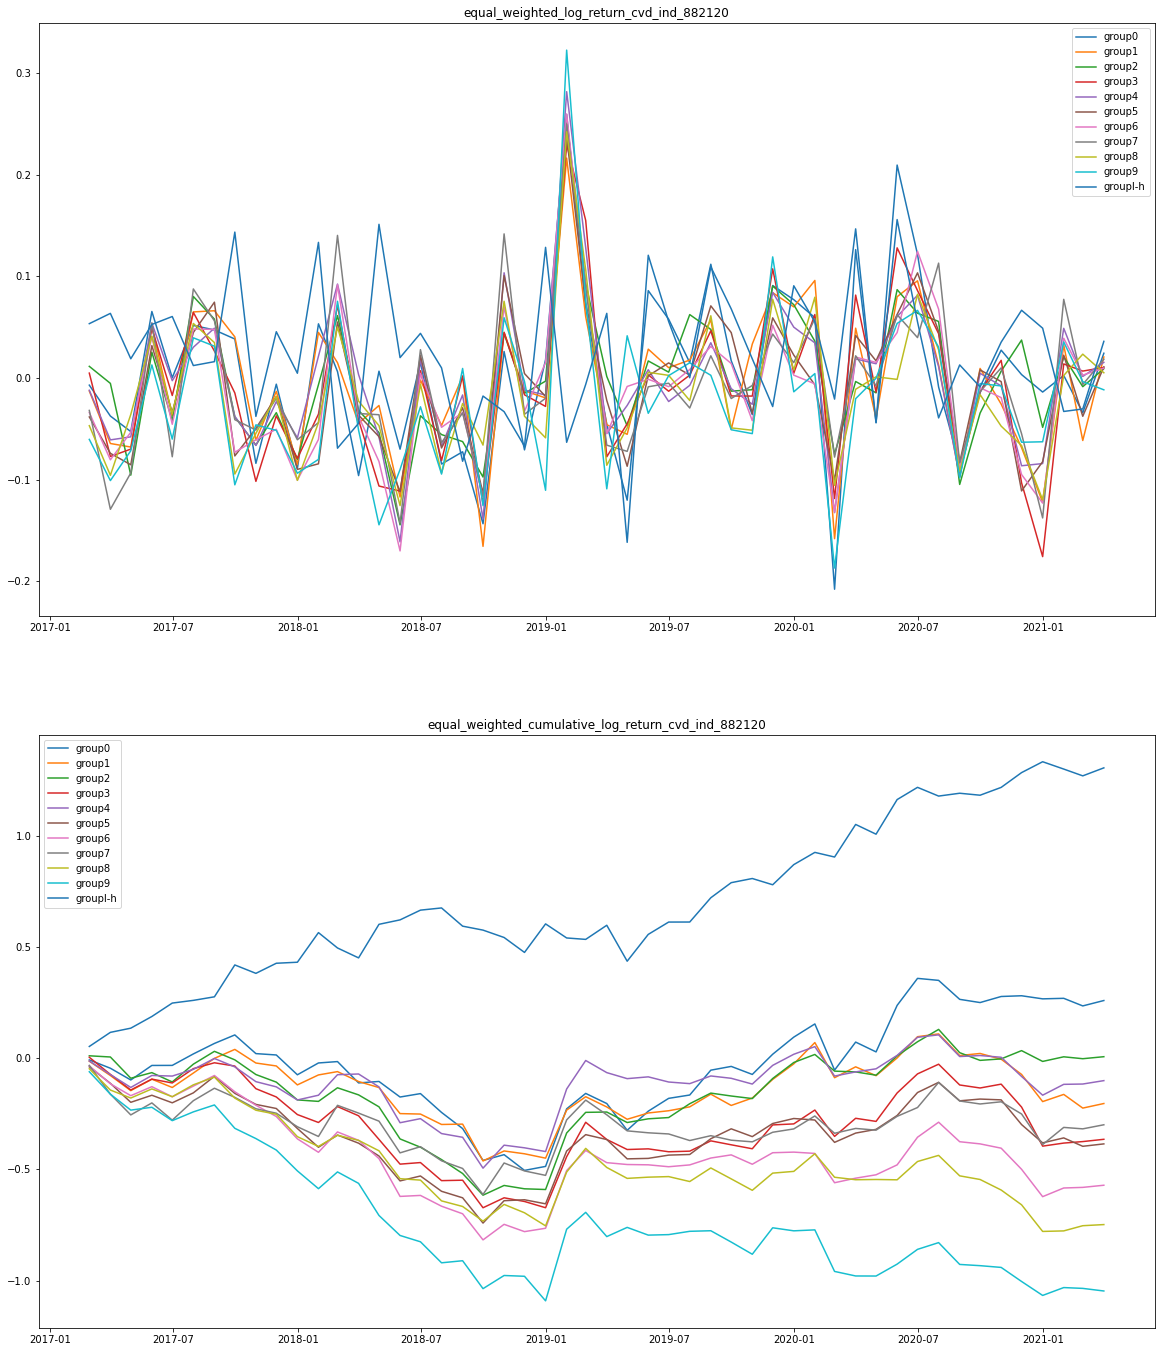

In [70]:
#882101等值加权
ind_882120_test.E_weight(ob_t = ob_t,tt='cvd_ind_882120')

TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0        0.8485       0.1589  0.506    [0.0118, 0.8588]     [0.238, 0.8617]   
1       -0.1697      -0.0437 -0.703  [-0.0036, -0.3317]   [-0.0412, -0.187]   
2        0.2616       0.0574  0.137    [0.0043, 0.3817]     [0.1972, 0.881]   
3       -0.2009      -0.0524 -0.936  [-0.0044, -0.4125]   [-0.0376, -0.175]   
4        0.1923       0.0431  0.047    [0.0036, 0.3079]  [-0.0188, -0.0811]   
5       -0.3527      -0.0991 -1.131   [-0.0089, -0.931]    [0.1053, 0.5485]   
6       -0.6012       -0.198  -1.09  [-0.0185, -1.2373]    [0.0451, 0.1504]   
7        -0.241       -0.064 -1.407  [-0.0057, -0.5336]     [0.0948, 0.442]   
8       -0.3589      -0.1012   -1.3   [-0.009, -0.8438]    [0.0316, 0.1486]   
9       -0.6786      -0.2385 -1.302  [-0.0228, -1.7632]    [0.0672, 0.2584]   
l-h      4.7515       0.5218  0.807    [0.0347, 2.4628]    [0.1708, 0.6048]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0       [0.0018, 0.126]     [0.0053, 0.341]       0.442  
1    [-0.0046, -0.3843]   [-0.001, -0.0727]       0.464  
2      [0.0056, 0.4624]    [0.0151, 1.1377]       0.497  
3    [-0.0009, -0.0744]    [0.0015, 0.1171]       0.401  
4      [0.0077, 0.6221]    [0.0167, 1.2205]        0.31  
5    [-0.0041, -0.4092]    [0.0045, 0.4018]       0.522  
6    [-0.0081, -0.5203]    [0.0075, 0.4414]       0.662  
7      [0.0058, 0.5547]    [0.0116, 1.0191]       0.354  
8     [-0.0015, -0.131]    [0.0086, 0.7096]         0.4  
9    [-0.0126, -0.9422]  [-0.0015, -0.1116]       0.673  
l-h     [0.0143, 1.211]     [0.0069, 0.524]       0.266

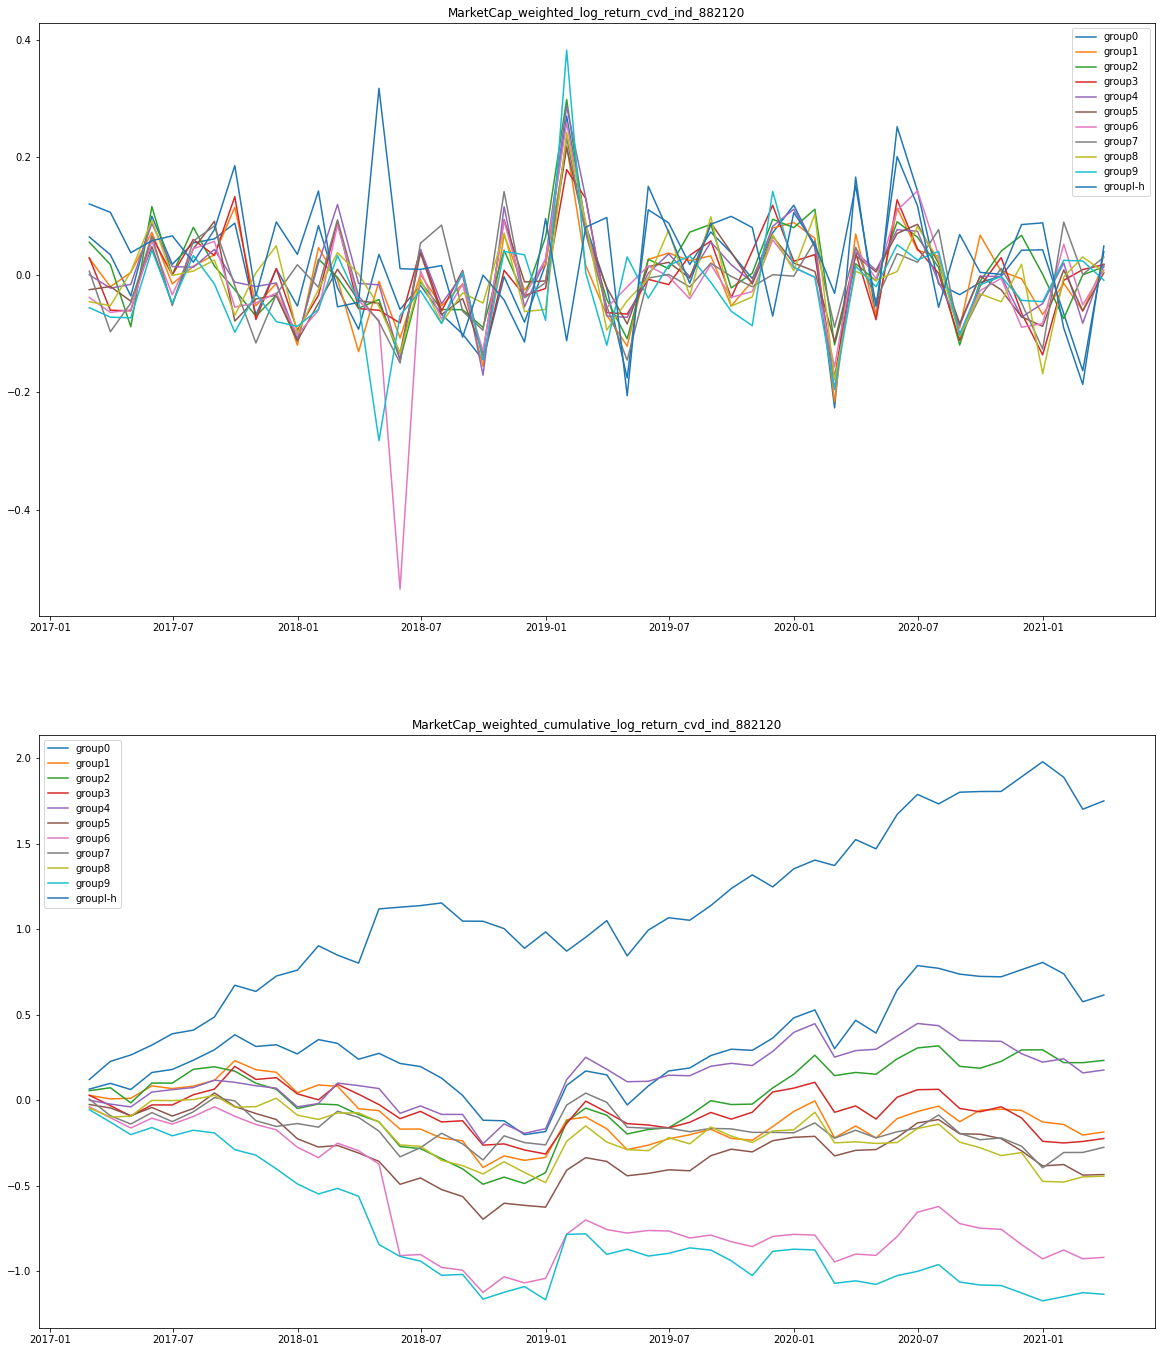

In [71]:
#882101市值加权
ind_882120_test.MC_weight(ob_t = ob_t,tt='cvd_ind_882120')

In [72]:
#取最近50个有效观察值
ob_t = Re.index[-51:-1]

def get_observations(Re,MarketCap,factors,ob_t):    
    #dropna and infs
    factor = factors.loc[ob_t,:].copy()
    #处理极端数据
    factor[factor>10]=np.NaN
    factor[factor==0]=np.NaN
    factor.dropna(axis=1,inplace=True)
    Re = Re.loc[ob_t,factor.columns].dropna(axis=1)
    factor = factor.loc[:,Re.columns]
    MarketCap = MarketCap.resample('M').last().loc[ob_t,factor.columns]
    return(Re,MarketCap,factor)

Re_latest,MarketCap_latest,cvd_latest = get_observations(Re,MarketCap,cvd,ob_t)
print('start_date ',ob_t[0],'\nend_date ',ob_t[-1])

start_date  2017-02-28 00:00:00 
end_date  2021-03-31 00:00:00


mean        0.135199
median     -0.093382
max         3.536109
min        -2.408190
std         1.105175
skewness    0.688062
kurtosis   -0.215127
dtype: float64


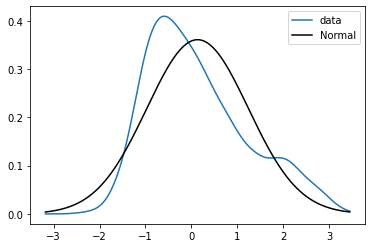

mean       -0.164438
median     -0.260966
max         2.916036
min        -2.830674
std         0.728064
skewness    0.598504
kurtosis    1.346955
dtype: float64


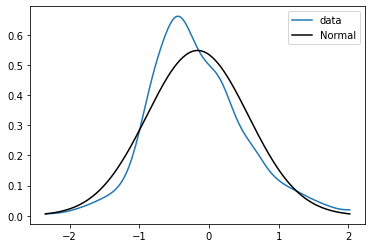

In [73]:
#回归分析的数据处理
#取log，同时对极端值进行处理，进行normalization
#cvd_latest=np.log(cvd_latest)
def normalization(data,ax=1):
    def centrilization(x):
        y=abs(x-x.median()).median()*5
        x[x>(x.median()+y)]=x.median()+y
        x[x<(x.median()-y)]=x.median()-y
        return(x)
    data=data.apply(centrilization,axis=ax)
    data=data.apply(lambda x: (x-x.mean())/x.std(),axis=ax)
    return(data)
cvd_norm = normalization(cvd_latest,ax=0)
Re_norm = normalization(Re_latest,ax=0)
statistics(cvd_norm.iloc[0,:])
statistics(Re_norm.iloc[0,:])

mean        -1.194452
mean(abs)    2.740123
std          3.324203
|t|>2        0.540000
dtype: float64


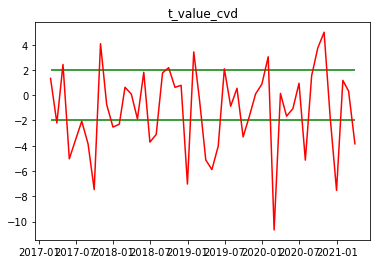

In [78]:
t_value = []
ob_t = Re.index[-51:-1]
for i in ob_t:
    X = np.mat(np.stack([np.ones(shape=cvd_norm.loc[i,:].shape),cvd_norm.loc[i,:]]).T)
    y = np.mat(Re_norm.loc[i,:].to_numpy()).T
    beta = (X.T*X).I*X.T*y
    u = y-X*beta

    #estimated variation of regression
    varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
    se = np.sqrt(np.diag(varbeta))

    #record estimation
    t_value.append((beta.T/se)[0,1])
t_value = pd.Series(t_value,index = ob_t)
plt.plot(t_value,color='red')
plt.hlines(2,ob_t[0],ob_t[-1],colors='green')
plt.hlines(-2,ob_t[0],ob_t[-1],colors='green')
plt.title('t_value_cvd')
print(pd.Series({'mean':np. mean(t_value),'mean(abs)':np.mean(abs(t_value)),'std':np.std(t_value),'|t|>2':t_value[abs(t_value)>2].count()/t_value.count()}))        